# Домашнее задание 3

In [1]:
import re
import math
from collections import Counter
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
with open('WarAndPeace.txt', 'r') as f:
    war_text_rus = f.read()
with open('WarAndPeaceEng.txt', 'r') as f:
    war_text_eng = f.read()
with open('AnnaKarenina.txt', 'r') as f:
    anna_text_rus = f.read()

In [3]:
war_text_rus = re.sub(r"\W+", " ", war_text_rus)
war_text_rus = war_text_rus.replace('  ', ' ').lower()
war_text_eng = re.sub(r"\W+", " ", war_text_eng)
war_text_eng = war_text_eng.replace('  ', ' ').lower()
anna_text_rus = re.sub(r"\W+", " ", anna_text_rus)
anna_text_rus = anna_text_rus.replace('  ', ' ').lower()

## Базовый частотный метод

In [4]:
def one_char_freq_encoder(origin_text, test_text):
    
    # считаем статистики на большом тексте
    freq_map = Counter()
    for char in origin_text:
        freq_map[char] += 1
    
    # перестановка сдигом на один символ
    encoder = dict()
    chars = list(freq_map.keys())
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]
    
    # кодируем тестовый текст
    encoded_test = []
    for char in test_text:
        if char in encoder:
            encoded_test.append(encoder[char])
    test_text = ''.join(encoded_test)
    
    # считаем статистики на закодированном тексте
    fitted_map = Counter()
    for char in test_text:
        fitted_map[char] += 1
    
    # сортируем словари (символ: количество) по частоте вхождения
    fitted_map = sorted(list(fitted_map.items()), key=lambda x: x[1], reverse=True)
    freq_map = sorted(list(freq_map.items()), key=lambda x: x[1], reverse=True)
    
    # создаем декодер по принципу (самый частый символ -> самый частый символ) по убыванию
    decoder = dict()
    for i in range(len(fitted_map)):
        decoder[fitted_map[i][0]] = freq_map[i][0]
    
    # Проверяем какие символы расшифровались верно
    correct_decoded = []
    for char in decoder:
        if char == encoder[decoder[char]]:
            correct_decoded.append(decoder[char])
    return round(len(correct_decoded) / len(decoder), 3), correct_decoded

Запускаем несколько раз и усредняем. Получается, что точность пропорциональна логарифму длины тестого текста примерно до 30 000 символов. Дальнейшее его увеличение не дает прирост точности

In [5]:
acc_array = []
len_array = []
for len_test in [100, 300, 1000, 3000, 10000, 30000, 100000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = war_text_eng[start_idx:start_idx+len_test]
        acc, _ = one_char_freq_encoder(war_text_eng, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

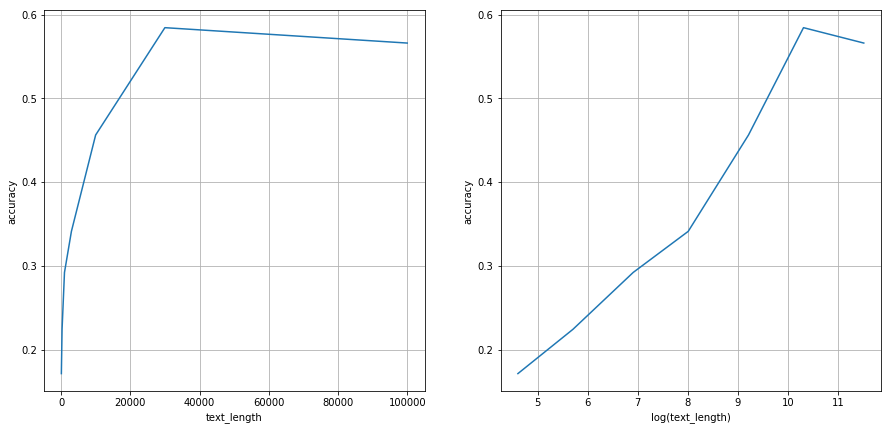

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

При тестировании на русском алфавите качетсво получилось хуже. Это логично, так как в русской версии обучающего текста встречаются латинские буквы, которые усложняют обучение и да и просто снижают Accuracy (плюс в качестве тестового текста использовался другой текст, а не отрывок обучающего)

In [7]:
acc_array = []
len_array = []
for len_test in [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = anna_text_rus[start_idx:start_idx+len_test]
        acc, _ = one_char_freq_encoder(war_text_rus, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

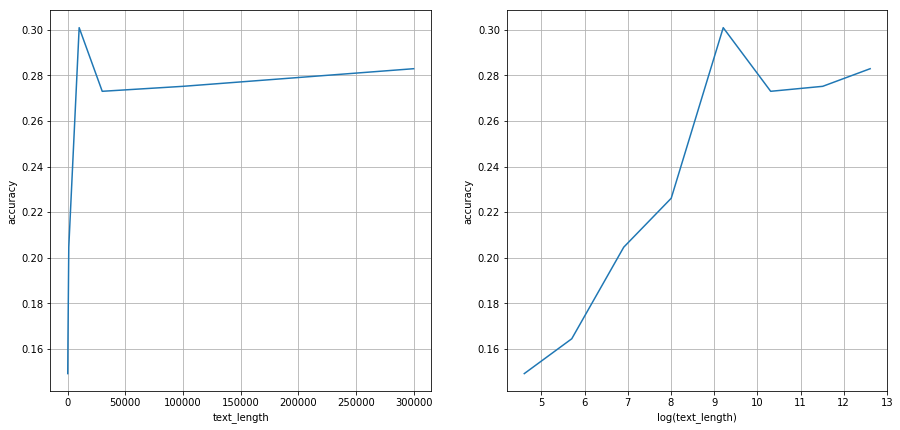

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

## Частотный метод на биграммах

In [9]:
def bigram_freq_encoder(origin_text, test_text):
    
    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1
            
    encoder = dict()
    chars = list(set(origin_text))
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]
    
    encoded_test = []
    for char in test_text:
        if char in encoder:
            encoded_test.append(encoder[char])
    test_text = ''.join(encoded_test)
    
    fitted_map = Counter()
    for i in range(len(test_text) - 1):
        pair = test_text[i:i+2]
        fitted_map[pair] += 1
            
    fitted_map = sorted(list(fitted_map.items()), key=lambda x: x[1], reverse=True)
    freq_map = sorted(list(freq_map.items()), key=lambda x: x[1], reverse=True)
    
    # так как теперь каждый символ встресается в нескольких биграммах,
    # запоминаем первые 10 вариантов, начиная с более частых (могут повторяться)
    decoder = dict()
    chars = []
    for i in range(len(fitted_map)):
        for j in range(2):
            char = fitted_map[i][0][j]
            if char not in chars:
                chars.append(char)
            if char not in decoder:
                decoder[char] = Counter()
            if sum(decoder[char].values()) < 10:
                decoder[char][freq_map[i][0][j]] += 1
    
    # для кажого символа выбираем самый популярный вариант расшифровки (кроме уже занятых)
    used = []
    res_decoder = dict()
    for char in chars:
        for pair in decoder[char].most_common():
            if pair[0] not in used:
                res_decoder[char] = pair[0]
                used.append(pair[0])
                break
                
    correct_decoded = []
    for char in res_decoder:
        if char == encoder[res_decoder[char]]:
            correct_decoded.append(res_decoder[char])
            
    return round(len(correct_decoded) / len(decoder), 3), correct_decoded

При использовании биграмм зависимость точности от длины текста не такая стойкая и в целом качество заметно хуже

In [10]:
acc_array = []
len_array = []
for len_test in [1000, 3000, 10000, 30000, 100000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = war_text_eng[start_idx:start_idx+len_test]
        acc, _ = bigram_freq_encoder(war_text_eng, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

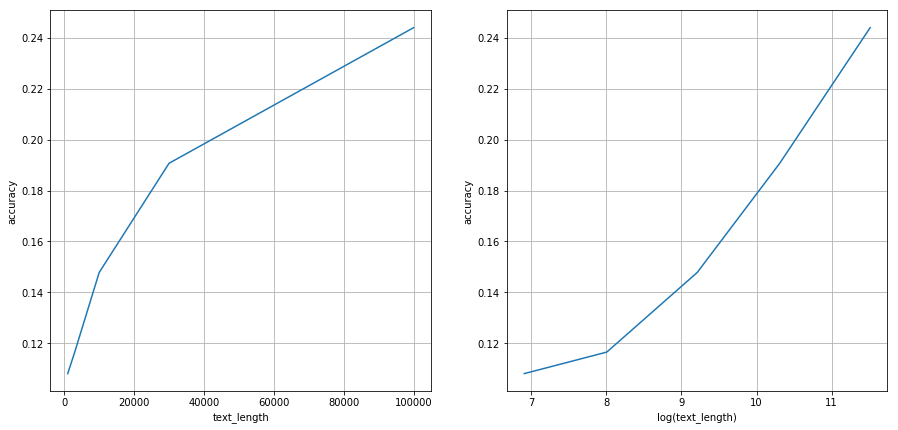

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

In [12]:
acc_array = []
len_array = []
for len_test in [100, 300, 1000, 3000, 10000, 30000, 100000, 300000]:
    tmp_acc = []
    for start_idx in range(10000, 210001, 20000):
        test_text = anna_text_rus[start_idx:start_idx+len_test]
        acc, _ = bigram_freq_encoder(war_text_rus, test_text)
        tmp_acc.append(acc)
    len_array.append(len_test)
    acc_array.append(sum(tmp_acc) / len(tmp_acc))

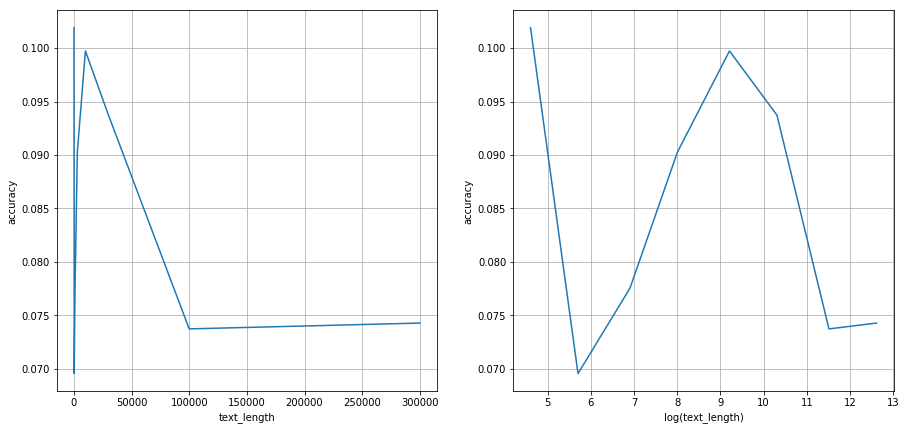

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(len_array, acc_array)
ax[0].grid()
ax[0].set_xlabel('text_length')
ax[0].set_ylabel('accuracy')
ax[1].plot([math.log(x) for x in len_array], acc_array)
ax[1].grid()
ax[1].set_xlabel('log(text_length)')
ax[1].set_ylabel('accuracy');

## Применение MCMC-сэмплирования

В качестве первой версии декодера возьмем тождественное преобразование. Один шаг - случайный swap двух символов декодера. На каждом шаге расшифровываем тестовое сообщение текущим и новым декодером. Если правдоподобие увеличилось, принимаем новый декодер, если нет - с вероятностью (новое / текущее)
Правдоподобие: p ~ p(bg1) * p(bg7) * p(bgi) ..., где каждый множитель соответсвует одной биграмме тетсового текста, двигаясь по одному символу - вероятность получить эту биграмму, обученная на основном тексте. Пусть всего биграмм M, а количество биграмм i в тестовом тексте N(i), тогда можно перписать 
p ~ (p(bg1)^N(1)) * (p(bg1)^N(1)) * ... * (p(bgM)^N(M))

In [14]:
def get_score(decoder, decoded_text, freq_map):
    
    # Расшифровываем текст полученным декодером
    decoded_text_arr = []
    for char in decoded_text:
        decoded_text_arr.append(decoder[char])
    decoded_text = ''.join(decoded_text_arr)
    
    # На получившемся тексте считаем количество биграмм
    fitted_map = Counter()
    for i in range(len(decoded_text) - 1):
        pair = decoded_text[i:i+2]
        fitted_map[pair] += 1
        
    score = 0
    for k, v in fitted_map.items():
        if k in freq_map:
            score += v * math.log(freq_map[k])
    return score

In [22]:
def mcmc_encoder(origin_text, test_text_len, idx_start):
    test_text = origin_text[idx_start:idx_start+test_text_len]

    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1
    
    # получаем частоту из количества
    for key in freq_map:
        freq_map[key] = freq_map[key] / len(origin_text)

    encoder = dict()
    chars = list(set(origin_text))
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]

    for i in range(len(test_text)):
        test_text = test_text[:i] + encoder[test_text[i]] + test_text[i + 1:]
    
    # начальная версия декодера
    cur_decoder = dict()
    for c in chars:
        cur_decoder[c] = c

    best_score = -9999999999
    best_decoder = cur_decoder
    
    for i in range(2000):
        # делаем случайную перестановку
        new_decoder = cur_decoder.copy()
        chars = list(new_decoder.keys())
        key_1 = random.choice(chars)
        chars.remove(key_1)
        key_2 = random.choice(chars)
        new_decoder[key_1], new_decoder[key_2] = new_decoder[key_2], new_decoder[key_1]

        cur_score = get_score(cur_decoder, test_text[:], freq_map)
        new_score = get_score(new_decoder, test_text[:], freq_map)
        
        diff = min(1, new_score - cur_score)
        prob = min(1, math.exp(diff))
        
        # сохраняем лучший декодер
        if new_score > best_score:
            best_score = new_score
            best_decoder = new_decoder
            
        # условие принятия нового декодера
        if prob >= random.uniform(0, 1):
            cur_decoder = new_decoder

    return best_decoder, encoder

Точность получается низкая

In [23]:
best_decoder, encoder = mcmc_encoder(war_text_eng, 20000, 30000)

In [24]:
correct_decoded = []
for char in best_decoder:
    if char == encoder[best_decoder[char]]:
        correct_decoded.append(best_decoder[char])
print(round(len(correct_decoded) / len(best_decoder), 3), correct_decoded)

0.024 ['v']


Алгоритм заработал при внесении двух изменений:
1. Не преобразовывать количества вхождений биграмм в основном тексте к частотам
2. Переходить только если правдоподобие увеличилось

In [25]:
def error_descent_encoder(origin_text, test_text_len, idx_start):
    test_text = origin_text[idx_start:idx_start+test_text_len]

    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1

    encoder = dict()
    chars = list(set(origin_text))
    for i in range(len(chars)):
        encoder[chars[i]] = chars[(i + 1) % len(chars)]

    for i in range(len(test_text)):
        test_text = test_text[:i] + encoder[test_text[i]] + test_text[i + 1:]

    cur_decoder = dict()
    for c in chars:
        cur_decoder[c] = c

    best_score = -9999999999
    best_decoder = cur_decoder
    
    for i in range(5000):
        new_decoder = cur_decoder.copy()
        chars = list(new_decoder.keys())
        key_1 = random.choice(chars)
        chars.remove(key_1)
        key_2 = random.choice(chars)
        new_decoder[key_1], new_decoder[key_2] = new_decoder[key_2], new_decoder[key_1]

        cur_score = get_score(cur_decoder, test_text[:], freq_map)
        new_score = get_score(new_decoder, test_text[:], freq_map)

        if new_score > best_score:
            best_score = new_score
            best_decoder = new_decoder
        if new_score > cur_score:
            cur_decoder = new_decoder

    return best_decoder, encoder

Точность получилась высокая

In [26]:
best_decoder, encoder = error_descent_encoder(war_text_eng, 20000, 30000)

In [27]:
correct_decoded = []
for char in best_decoder:
    if char == encoder[best_decoder[char]]:
        correct_decoded.append(best_decoder[char])
print("Доля расшифрованных символов", round(len(correct_decoded) / len(best_decoder), 3))
print("Расшифрованные символы", sorted(correct_decoded))
print("Нерасшифрованные символы", sorted(list(set(best_decoder.keys()) - set(correct_decoded))))

Доля расшифрованных символов 0.683
Расшифрованные символы [' ', '1', '9', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ê']
Нерасшифрованные символы ['0', '2', '3', '4', '5', '6', '7', '8', 'f', 'k', 'à', 'ä', 'é']


## Расшифровка сообщения

Воспользуемся последним из описанных выше методов

In [301]:
def error_descent_encoder_secret(origin_text, test_text):
    
    freq_map = Counter()
    for i in range(len(origin_text) - 1):
        pair = origin_text[i:i+2]
        freq_map[pair] += 1
    
    # Подготовим множества символов
    rus_alf = [chr(c) for c in range(ord('а'), ord('а')+32)] + ['ё', ' ']
    secret_alf = list(set(test_text))
    secret_alf = secret_alf + [str(i) for i in range(len(rus_alf) - len(secret_alf))]

    # Начальная версия декодера
    cur_decoder = dict()
    for i in range(len(rus_alf)):
        cur_decoder[secret_alf[i]] = rus_alf[i]
    
    best_score = -9999999999
    prev_best_score = best_score
    best_decoder = cur_decoder
    i = 0
    while True:
        i += 1
        new_decoder = cur_decoder.copy()
        chars = list(new_decoder.keys())
        key_1 = random.choice(chars)
        chars.remove(key_1)
        key_2 = random.choice(chars)
        new_decoder[key_1], new_decoder[key_2] = new_decoder[key_2], new_decoder[key_1]

        cur_score = get_score(cur_decoder, test_text[:], freq_map)
        new_score = get_score(new_decoder, test_text[:], freq_map)

        if new_score > best_score:
            best_score = new_score
            best_decoder = new_decoder
        if new_score > cur_score:
            cur_decoder = new_decoder
    
        # Если за 5000 итераций скор не прибавился, выходим
        if i % 5000 == 0:
            if best_score == prev_best_score:
                break
            prev_best_score = best_score

    for j in range(len(test_text)):
        test_text = test_text[:j] + best_decoder[test_text[j]] + test_text[j + 1:]
    print(i, best_score, test_text[:7])
    return best_decoder, test_text

Во время работы с сообщением была получена корректная расшифровка. Так как получать ее стабильно не получается, будем проводить итерации, пока не получим нужное начало сообщения

In [302]:
secret_text = 'დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ'

In [307]:
while True:
    best_decoder, decoded_text = error_descent_encoder_secret(war_text_rus, secret_text)
    if decoded_text[:7] == 'если вы':
        break

10000 1556.7606276908368 кто нья
10000 1657.2677530225983 ниям ст
10000 1626.1675852816895 нротекл
10000 1675.1070310661955 лков гр
10000 1604.7872772851306 етиднаш
10000 1600.0893056556242 сдертуй
10000 1627.3722790081554 траледп
10000 1620.607198574549 есотнал
10000 1584.8021795373545 еястназ
10000 1774.4975540365947 евни зь
10000 1615.2917163384234 сдетния
10000 1734.5915495426382 енси мл
15000 1777.1110368800385 еули вы
10000 1672.4853123240912 нкор пл
10000 1678.442169661486 тдивосп
15000 1608.9990358138657 втернуш
10000 1634.0883325165653 едитняз
10000 1649.057795641526 тди оюл
15000 1673.7296359021386 исноему
10000 1682.6599116330813 лков ст
10000 1625.213967678112 нситеюб
10000 1686.8705403187562 ндев зм
10000 1782.9983633804143 ерли ты
15000 1784.8074356304312 евни сь
10000 1622.9720495681227 ндесову
15000 1670.2720661902588 евин ст
10000 1763.0978763756343 евна зь
10000 1682.5559209916687 нкот сз
10000 1594.018179761542  тосназ
10000 1588.5830926108865 ласвитр
10000 1752.6604

In [308]:
decoded_text

'если вы вимите норжальный или подти норжальный текст у этого сообщения который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный балл ча послемнее детвертое чамание курса зотя конедно я нидего не обещаш'